## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [2]:
from TCGame_Env import TicTacToe # import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env


    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

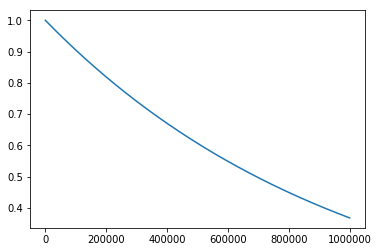

In [6]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

epsilon = []
max_epsilon = 1.0
min_epsilon = 0.001

EPISODES= np.arange(0, 1000000)

for i in EPISODES:
    epsilon.append(min_epsilon +
                   (max_epsilon - min_epsilon) * np.exp(-0.000001 * i))

plt.plot(EPISODES, epsilon)
plt.show()




#### Tracking the state-action pairs for checking convergence - write your code here

In [7]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

print(len(Q_dict))
print(len(States_track))

0
0


In [8]:
# Initialise states to be tracked
def initialise_tracking_states():
    state_action_pair = [('x-7-3-x-2-8-x-x-x', (0, 1)),
                         ('x-1-2-x-7-x-x-6-x', (3, 3)),
                         ('x-1-x-x-x-x-8-6-7', (0, 3)),
                         ('6-x-7-x-x-1-x-x-4', (1, 5)),
                         ('x-x-x-4-9-2-7-x-x', (1, 1)),
                         ('x-x-3-8-2-x-x-x-5', (0, 1)),
                         ('3-x-7-x-x-x-x-8-2', (5, 5)),
                         ('2-x-1-8-x-7-x-x-x', (4, 3)),
                         ('1-x-3-x-6-x-x-4-x', (1, 5))] 
    for st, ac in state_action_pair:
        States_track[st][ac] = list()

  
  
  
  

In [9]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [11]:
initialise_tracking_states()

In [12]:
def action_selection(state, episodes):

    max_epsilon = 1.0
    min_epsilon = 0.001
    
    random_value = np.random.random()
    
    # As the number of episodes increases epsilon value decreases
    
    epsilon_value = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.00001 * episodes)
    
    if random_value > epsilon_value:
        # exploitation 
        proposed_action = max(Q_dict[Q_state(state)],
                              key=Q_dict[Q_state(state)].get)
    else:
        # exploration 
        proposed_action = random.choice(
            [ac for itr, ac in enumerate(env.action_space(state)[0])])
    
    return proposed_action

#### Define hyperparameters  ---write your code here

In [13]:
EPISODES = 1000000

learning_rate=0.01
gamma = 0.91

tracking_state_checkpoint = 1000
episodes_checkpoint = 10000

### Q-update loop ---write your code here

In [14]:
start_time = time.time()
agent_win_cnt = 0
env_win_cnt = 0
tie_count = 0

reward_state = None
for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    # build a new environment 
    env = TicTacToe()

    #new state 
    current_state = env.state

    # add current state to Q - dict
    add_to_dict(current_state)
    
    reward_state = None
    
    is_terminal_state = False
    
    # continue playing until any terminal state is reached     
    while not is_terminal_state:
        
        # using epsilon greedy strategy 
        agent_action = action_selection(current_state, episode)
        
        
        # save - next_state, reward, terminal state         
        next_state, reward, is_terminal_state, msg = env.step(
            current_state, agent_action)

        add_to_dict(next_state)

        current_state_key = Q_state(current_state)
        reward_state = current_state_key

        if is_terminal_state:
            # terminal state - either a tie or a win by agent or environment
            if msg == "Agent Win":
                agent_win_cnt += 1

            elif msg == "Environment Win":
                env_win_cnt += 1
                
            else:
                tie_count += 1
                
            next_best_action = None
            
            # in a terminal state, Q - value of next state will be ZERO
            Q_dict[Q_state(current_state)][agent_action] += learning_rate * (
                (reward +
                 (gamma * 0)) - Q_dict[Q_state(current_state)][agent_action])
        else:
            # generate 'best next action' corresponding to next state from Q - dictionary
            next_best_action = max(Q_dict[Q_state(next_state)],
                                   key=Q_dict[Q_state(next_state)].get)
            
            # update q-value of (current state, agent action) pair
            Q_dict[Q_state(current_state)][agent_action] += learning_rate * (
                (reward + (gamma *
                           (Q_dict[Q_state(next_state)][next_best_action]))) -
                Q_dict[Q_state(current_state)][agent_action])

        current_state = next_state

    
    if (episode + 1) % episodes_checkpoint == 0:
        print(
            "After playing %d games, Agent Win : %.4f, Environment Win : %.4f, Tie(s) : %.4f"
            % (episode + 1, agent_win_cnt / (episode + 1), env_win_cnt /
               (episode + 1), tie_count / (episode + 1)))

    if (episode + 1) % tracking_state_checkpoint == 0:
        save_tracking_states()

        
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print("Elapsed time :", elapsed_time)

After playing 10000 games, Agent Win : 0.2541, Environment Win : 0.2806, Tie(s) : 0.4653
After playing 20000 games, Agent Win : 0.2539, Environment Win : 0.2799, Tie(s) : 0.4662
After playing 30000 games, Agent Win : 0.2515, Environment Win : 0.2818, Tie(s) : 0.4667
After playing 40000 games, Agent Win : 0.2525, Environment Win : 0.2815, Tie(s) : 0.4661
After playing 50000 games, Agent Win : 0.2538, Environment Win : 0.2811, Tie(s) : 0.4651
After playing 60000 games, Agent Win : 0.2544, Environment Win : 0.2805, Tie(s) : 0.4651
After playing 70000 games, Agent Win : 0.2549, Environment Win : 0.2800, Tie(s) : 0.4651
After playing 80000 games, Agent Win : 0.2561, Environment Win : 0.2781, Tie(s) : 0.4658
After playing 90000 games, Agent Win : 0.2570, Environment Win : 0.2779, Tie(s) : 0.4651
After playing 100000 games, Agent Win : 0.2577, Environment Win : 0.2775, Tie(s) : 0.4647
After playing 110000 games, Agent Win : 0.2595, Environment Win : 0.2773, Tie(s) : 0.4632
After playing 12000

After playing 930000 games, Agent Win : 0.3454, Environment Win : 0.2420, Tie(s) : 0.4127
After playing 940000 games, Agent Win : 0.3461, Environment Win : 0.2416, Tie(s) : 0.4123
After playing 950000 games, Agent Win : 0.3469, Environment Win : 0.2413, Tie(s) : 0.4118
After playing 960000 games, Agent Win : 0.3478, Environment Win : 0.2409, Tie(s) : 0.4113
After playing 970000 games, Agent Win : 0.3486, Environment Win : 0.2406, Tie(s) : 0.4108
After playing 980000 games, Agent Win : 0.3495, Environment Win : 0.2403, Tie(s) : 0.4102
After playing 990000 games, Agent Win : 0.3504, Environment Win : 0.2400, Tie(s) : 0.4096
After playing 1000000 games, Agent Win : 0.3512, Environment Win : 0.2397, Tie(s) : 0.4091
Elapsed time : 2799.60528588295


#### Check the Q-dictionary

In [15]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.2405599510922223,
              (0, 3): -1.2408128903238145,
              (0, 5): -1.240743892870424,
              (0, 7): -1.2405330896122055,
              (0, 9): -1.2406588870656843,
              (1, 1): -1.240585316404575,
              (1, 3): -1.2405317120842843,
              (1, 5): -1.2405557039464468,
              (1, 7): -1.2405542862287406,
              (1, 9): -1.2405553662818125,
              (2, 1): -1.240847406231346,
              (2, 3): -1.240542413978203,
              (2, 5): -1.2406628245066498,
              (2, 7): -1.2411585638816454,
              (2, 9): -1.2405744481939496,
              (3, 1): -1.240796557560861,
              (3, 3): -1.2405972337151188,
              (3, 5): -1.2405367924336412,
              (3, 7): -1.2405662556277874,
              (3, 9): -1.2406297974450409,
              (4, 1): -1.2406074591357874,
              (4, 3): -1.2393758207001375,
              (4, 5)

In [16]:
len(Q_dict)

1365384

In [17]:
print('Agent Win Count - {0}'.format(agent_win_cnt))

print('Eenvironment Win Count - {0}'.format(env_win_cnt))

print('Tie count - {0}'.format(tie_count))

Agent Win Count - 351231
Eenvironment Win Count - 239656
Tie count - 409113


In [18]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

state_track_qval = collections.defaultdict(dict)

for state in States_track.keys():
    for action in States_track[state].keys():
        qvals = States_track[state][action]
        total_tracked = len(qvals)
        state_track_qval[state][action] = total_tracked
            
state_track_qval

defaultdict(dict,
            {'x-7-3-x-2-8-x-x-x': {(0, 1): 857},
             'x-1-2-x-7-x-x-6-x': {(3, 3): 826},
             'x-1-x-x-x-x-8-6-7': {(0, 3): 906},
             '6-x-7-x-x-1-x-x-4': {(1, 5): 616},
             'x-x-x-4-9-2-7-x-x': {(1, 1): 717},
             'x-x-3-8-2-x-x-x-5': {(0, 1): 956},
             '3-x-7-x-x-x-x-8-2': {(5, 5): 981},
             '2-x-1-8-x-7-x-x-x': {(4, 3): 925},
             '1-x-3-x-6-x-x-4-x': {(1, 5): 907}})

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [19]:
# Write the code for plotting the graphs for state-action pairs tracked

In [20]:

def plot_q_val_convergence(state, action):

    iterations = state_track_qval[state][action]
    plt.plot(range(0, iterations), States_track[state][action])
    
    
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

<Figure size 1440x1080 with 0 Axes>

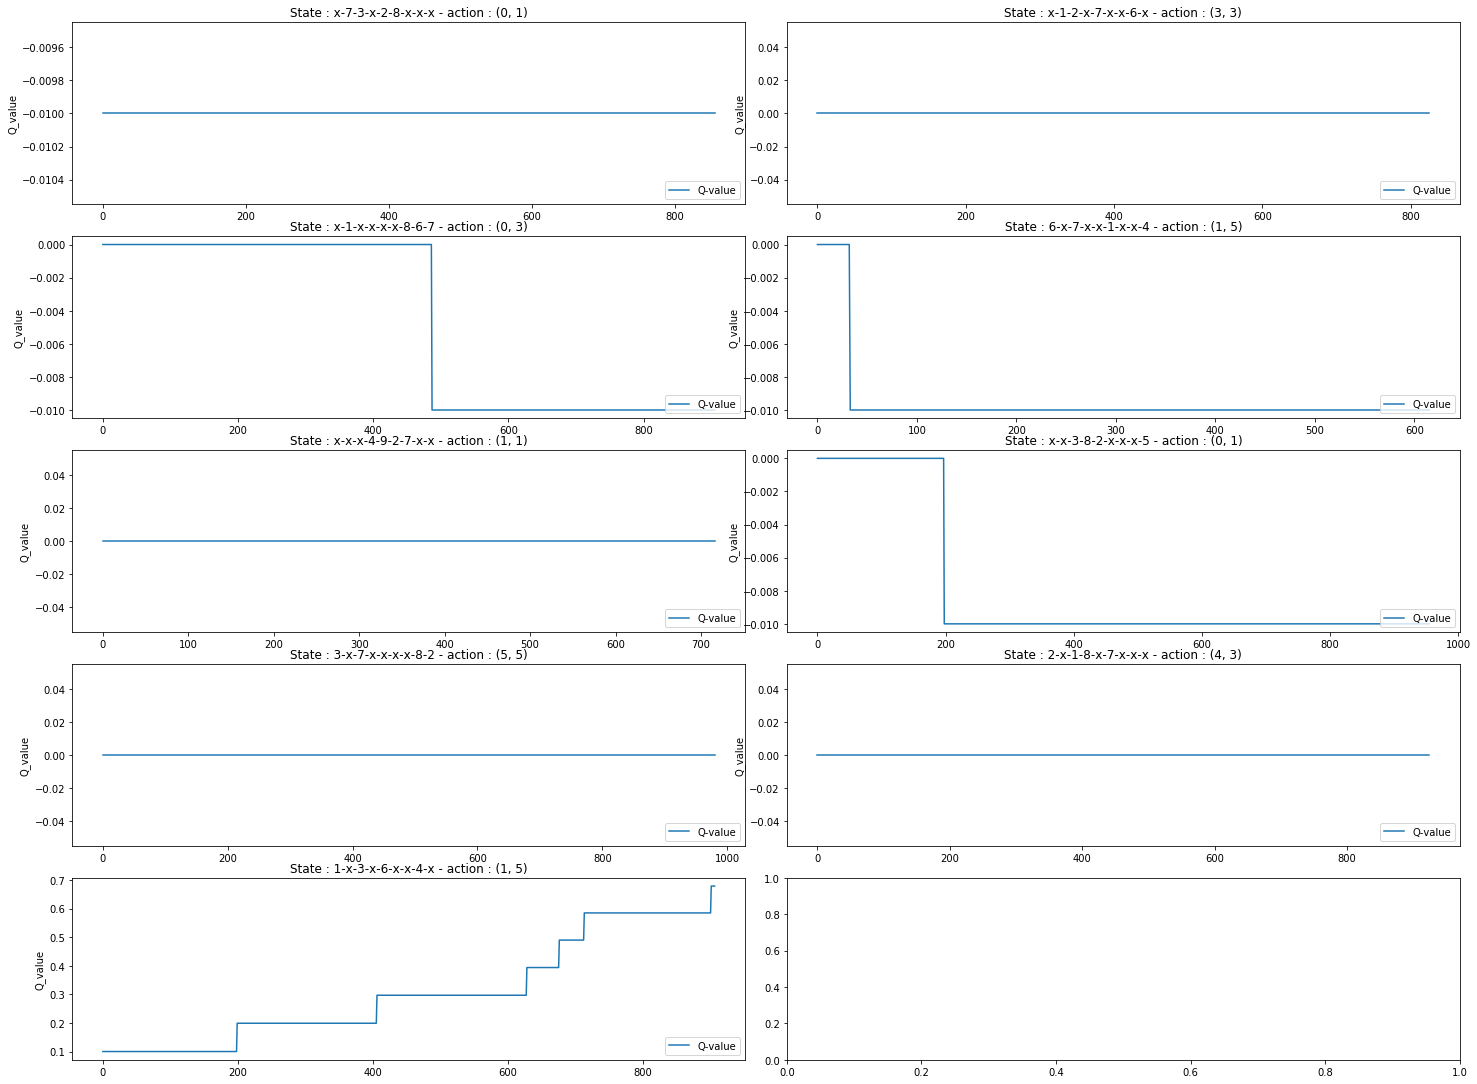

In [21]:
plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 15))
fig.tight_layout()

subplots = [i for i in range(521, 530)]

i = 0

for state in state_track_qval.keys():
    for action in state_track_qval[state].keys():
        plt.subplot(subplots[i])
        plot_q_val_convergence(state, action)
        i +=1

plt.show()

### Epsilon - decay check

In [22]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

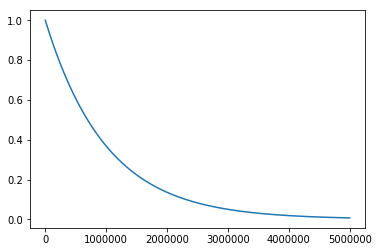

In [23]:
plt.plot(time, epsilon)
plt.show()